# 1 - TRAINIGN USING POPULATION

In [1]:
# Import necessary libraries
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define the DQN class
class DQN(nn.Module):
    def __init__(self, input_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# Define the SugarscapeEnvironment class with population-based reward system
class SugarscapeEnvironment:
    def __init__(self, width, height, num_agents, params):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.params = params

        # Initialize environment components
        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.max_sugar_landscape = self.sugar.copy()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        self.timestep = 0

        # Initialize DQN components
        self.observation_space_size = (self.params['vision_range'] * 2 + 1) ** 2 + 2  # Observation size
        self.action_space_size = 5  # Up, Down, Left, Right, Stay
        self.policy_net = DQN(self.observation_space_size, self.action_space_size)
        self.target_net = DQN(self.observation_space_size, self.action_space_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.params['learning_rate'])
        self.memory = deque(maxlen=100000)  # Increased buffer size for more experiences
        self.batch_size = self.params['batch_size']
        self.gamma = self.params['gamma']
        self.epsilon = self.params['epsilon_start']

        # Directory where checkpoints are saved (using absolute path)
        self.checkpoint_dir = os.path.abspath('./checkpoints')  # Change this path as needed

        # Create checkpoint directory if it doesn't exist
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Load latest checkpoint if available
        self.start_episode = self.load_latest_checkpoint()

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id, 'x': x, 'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': np.random.randint(1, self.params['vision_range'] + 1),
            'broadcast_radius': max(1, int(np.random.normal(self.params['broadcast_radius'], self.params['broadcast_radius'] / 3))),
            'messages': deque(maxlen=100),
            'destination': None,
            'done': False,
            'experience': []  # Store experiences during the episode
        }

    def get_agent_observation(self, agent):
        x, y = agent['x'], agent['y']
        obs_range = self.params['vision_range']
        # Get local sugar levels
        sugar_obs = self.sugar[max(0, y - obs_range):min(self.height, y + obs_range + 1),
                               max(0, x - obs_range):min(self.width, x + obs_range + 1)]
        # Pad the observation if at the edges
        pad_width_x = (max(0, obs_range - x), max(0, x + obs_range + 1 - self.width))
        pad_width_y = (max(0, obs_range - y), max(0, y + obs_range + 1 - self.height))
        sugar_obs = np.pad(sugar_obs, (pad_width_y, pad_width_x), mode='constant', constant_values=0)
        sugar_obs = sugar_obs.flatten()
        # Include agent's own sugar level and metabolism
        agent_features = np.array([agent['sugar'], agent['metabolism']])
        observation = np.concatenate((sugar_obs, agent_features))
        return observation

    def select_action(self, observation):
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            action = random.randint(0, self.action_space_size - 1)
        else:
            with torch.no_grad():
                observation = torch.tensor(observation, dtype=torch.float32)
                q_values = self.policy_net(observation)
                action = torch.argmax(q_values).item()
        return action

    def move_agent(self, agent, action):
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, max(0, y - 1)),        # Up
            1: (x, min(self.height - 1, y + 1)),  # Down
            2: (max(0, x - 1), y),        # Left
            3: (min(self.width - 1, x + 1), y),   # Right
            4: (x, y)                     # Stay
        }
        new_x, new_y = possible_moves[action]
        if (new_x, new_y) not in self.agent_positions:
            self.agent_positions.remove((agent['x'], agent['y']))
            agent['x'], agent['y'] = new_x, new_y
            self.agent_positions.add((new_x, new_y))
        # else: If the space is occupied, the agent stays in place

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # For each agent, perform action and collect experience
        for agent in self.agents:
            observation = self.get_agent_observation(agent)
            action = self.select_action(observation)
            self.move_agent(agent, action)
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            done = agent['sugar'] <= 0

            next_observation = self.get_agent_observation(agent)

            # Store experience without reward for now
            agent['experience'].append((observation, action, next_observation, done))

            agent['done'] = done

        # Update agent list
        alive_agents = []
        for agent in self.agents:
            if agent['done']:
                agent['death_time'] = self.timestep  # Add death_time to agent
                self.dead_agents.append(agent)       # Keep full agent data
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.timestep += 1

    def learn(self):
        if len(self.memory) < self.batch_size:
            return  # Not enough samples to learn

        batch = random.sample(self.memory, self.batch_size)
        observations, actions, rewards, next_observations, dones = zip(*batch)

        # Convert observations to torch tensors efficiently
        observations = torch.tensor(np.array(observations), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_observations = torch.tensor(np.array(next_observations), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        q_values = self.policy_net(observations).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_net(next_observations).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train_model(self, num_episodes, max_timesteps):
        for episode in range(self.start_episode, num_episodes):
            # Reset environment
            self.reset_environment()
            for timestep in range(max_timesteps):
                self.step()
                if not self.agents:
                    break  # All agents have died

            # At the end of the episode, calculate total surviving agents
            total_surviving_agents = len(self.agents)
            episode_reward = total_surviving_agents
            print(f"Episode {episode+1}/{num_episodes}, Surviving Agents: {total_surviving_agents}, Epsilon: {self.epsilon:.4f}")

            # Assign the same reward to all experiences in this episode
            # Iterate over all experiences from both dead and alive agents
            for agent in self.dead_agents + self.agents:
                for experience in agent['experience']:
                    observation, action, next_observation, done = experience
                    # Assign the reward based on total surviving agents
                    reward = episode_reward
                    # Store the experience with reward in the replay buffer
                    self.memory.append((observation, action, reward, next_observation, done))

            # Perform learning steps
            for _ in range(self.params.get('learning_steps_per_episode', 1)):
                self.learn()

            # Decay epsilon at the end of the episode
            if self.epsilon > self.params['epsilon_min']:
                self.epsilon *= self.params['epsilon_decay']
                self.epsilon = max(self.epsilon, self.params['epsilon_min'])

            # Save checkpoint periodically
            if (episode + 1) % self.params['save_interval'] == 0:
                self.save_checkpoint(episode + 1)
                print(f"Saved checkpoint at episode {episode+1}")

            # Update target network periodically
            if (episode + 1) % self.params['target_update'] == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                print(f"Updated target network at episode {episode+1}")

    def save_checkpoint(self, episode):
        checkpoint = {
            'episode': episode,
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
        }
        checkpoint_path = os.path.join(self.checkpoint_dir, f"checkpoint_episode_{episode}.pth")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    def load_latest_checkpoint(self):
        # Get list of all checkpoint files
        checkpoint_files = glob.glob(os.path.join(self.checkpoint_dir, 'checkpoint_episode_*.pth'))
        if not checkpoint_files:
            print("No checkpoint found. Starting training from scratch.")
            return 0  # No checkpoint found, start from episode 0

        # Extract episode numbers from filenames
        try:
            episode_numbers = [int(os.path.basename(f).split('_')[-1].split('.')[0]) for f in checkpoint_files]
        except ValueError:
            print("No valid checkpoint files found. Starting training from scratch.")
            return 0

        max_episode = max(episode_numbers)
        latest_checkpoint = os.path.join(self.checkpoint_dir, f'checkpoint_episode_{max_episode}.pth')

        # Load the checkpoint
        try:
            checkpoint = torch.load(latest_checkpoint)
            self.policy_net.load_state_dict(checkpoint['model_state_dict'])
            self.target_net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.epsilon = checkpoint['epsilon']
            print(f"Loaded checkpoint from episode {checkpoint['episode']} at {latest_checkpoint}")
            return checkpoint['episode']
        except Exception as e:
            print(f"Failed to load checkpoint from {latest_checkpoint}: {e}")
            print("Starting training from scratch.")
            return 0

    def reset_environment(self):
        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []
        self.timestep = 0

# Training Parameters
params = {
    'max_sugar': 5,
    'growth_rate': 1,
    'sugar_peak_frequency': 0.04,
    'sugar_peak_spread': 6,
    'job_center_duration': (40, 100),
    'vision_range': 1,
    'message_expiry': 15,
    'max_relay_messages': 10,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_min': 0.1,
    'epsilon_decay': 0.995,
    'learning_rate': 1e-4,
    'batch_size': 64,
    'target_update': 5,  # Update target network every 5 episodes
    'broadcast_radius': 15,
    'save_interval': 10,  # Save model every 10 episodes
    'learning_steps_per_episode': 10  # Number of learning steps per episode
}

# Create environment and train
env = SugarscapeEnvironment(width=50, height=50, num_agents=1000, params=params)
num_episodes = 2000  # Adjust as needed
max_timesteps = 1000

env.train_model(num_episodes, max_timesteps)

# Save the final model checkpoint
final_checkpoint = {
    'episode': num_episodes,
    'model_state_dict': env.policy_net.state_dict(),
    'optimizer_state_dict': env.optimizer.state_dict(),
    'epsilon': env.epsilon,
}
final_checkpoint_path = os.path.join(env.checkpoint_dir, "checkpoint_final.pth")
torch.save(final_checkpoint, final_checkpoint_path)
print(f"Training complete. Saved final model checkpoint at {final_checkpoint_path}")


Loaded checkpoint from episode 200 at c:\Users\Neo\Documents\Wits\Honours\Semester 1\IRM\Sugarscape\RL\checkpoints\checkpoint_episode_200.pth
Episode 201/2000, Surviving Agents: 162, Epsilon: 0.3670
Episode 202/2000, Surviving Agents: 32, Epsilon: 0.3651
Episode 203/2000, Surviving Agents: 65, Epsilon: 0.3633
Episode 204/2000, Surviving Agents: 94, Epsilon: 0.3615
Episode 205/2000, Surviving Agents: 92, Epsilon: 0.3597
Updated target network at episode 205
Episode 206/2000, Surviving Agents: 48, Epsilon: 0.3579
Episode 207/2000, Surviving Agents: 169, Epsilon: 0.3561
Episode 208/2000, Surviving Agents: 203, Epsilon: 0.3543
Episode 209/2000, Surviving Agents: 95, Epsilon: 0.3525
Episode 210/2000, Surviving Agents: 0, Epsilon: 0.3508
Checkpoint saved at c:\Users\Neo\Documents\Wits\Honours\Semester 1\IRM\Sugarscape\RL\checkpoints\checkpoint_episode_210.pth
Saved checkpoint at episode 210
Updated target network at episode 210
Episode 211/2000, Surviving Agents: 42, Epsilon: 0.3490
Episode 

KeyboardInterrupt: 

Loaded model_state_dict from checkpoint_episode_850.pth


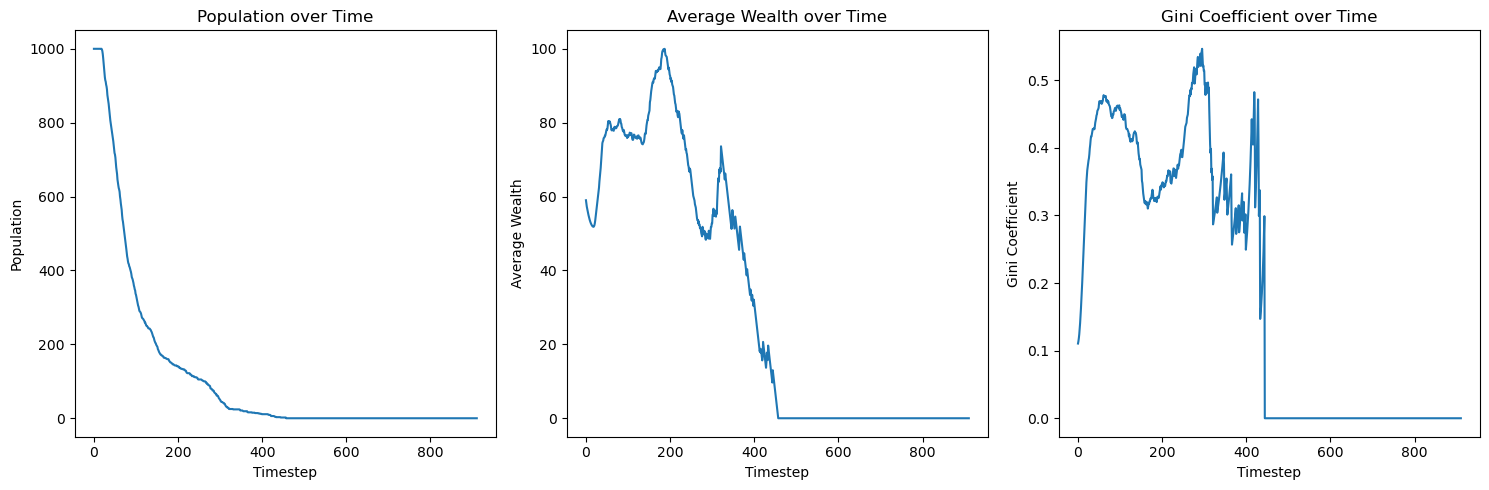

In [4]:
# Import necessary libraries
import random
import numpy as np
import pygame
import torch
import torch.nn as nn
from collections import deque
import matplotlib.pyplot as plt

# Define the DQN class (must match the one used during training)
class DQN(nn.Module):
    def __init__(self, input_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

class SugarscapeEnvironmentVisual:
    def __init__(self, width, height, num_agents, params, checkpoint_path):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.params = params

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.max_sugar_landscape = self.sugar.copy()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        # Initialize PyGame
        pygame.init()
        self.cell_size = 8  # Adjusted for better visibility
        self.screen = pygame.display.set_mode((width * self.cell_size, height * self.cell_size))
        pygame.display.set_caption("Sugarscape Simulation - Execution")
        self.clock = pygame.time.Clock()

        self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

        # Load trained model
        self.observation_space_size = (self.params['vision_range'] * 2 + 1) ** 2 + 2  # Observation size
        self.action_space_size = 5  # Up, Down, Left, Right, Stay
        self.policy_net = DQN(self.observation_space_size, self.action_space_size)
        
        # Load the checkpoint and extract model_state_dict
        try:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            if 'model_state_dict' in checkpoint:
                self.policy_net.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded model_state_dict from {checkpoint_path}")
            else:
                # If the checkpoint only contains the model's state_dict
                self.policy_net.load_state_dict(checkpoint)
                print(f"Loaded model state_dict directly from {checkpoint_path}")
        except Exception as e:
            print(f"Failed to load checkpoint from {checkpoint_path}: {e}")
            print("Proceeding with randomly initialized model.")
        
        self.policy_net.eval()

    # Include all necessary methods from the training environment
    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id, 'x': x, 'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': np.random.randint(1, self.params['vision_range'] + 1),
            'broadcast_radius': max(1, int(np.random.normal(self.params['broadcast_radius'], self.params['broadcast_radius'] / 3))),
            'messages': deque(maxlen=100),
            'destination': None,
            'done': False
        }

    def get_agent_observation(self, agent):
        x, y = agent['x'], agent['y']
        obs_range = self.params['vision_range']
        # Get local sugar levels
        sugar_obs = self.sugar[max(0, y - obs_range):min(self.height, y + obs_range + 1),
                               max(0, x - obs_range):min(self.width, x + obs_range + 1)]
        # Pad the observation if at the edges
        pad_width_x = (max(0, obs_range - x), max(0, x + obs_range + 1 - self.width))
        pad_width_y = (max(0, obs_range - y), max(0, y + obs_range + 1 - self.height))
        sugar_obs = np.pad(sugar_obs, (pad_width_y, pad_width_x), mode='constant', constant_values=0)
        sugar_obs = sugar_obs.flatten()
        # Include agent's own sugar level and metabolism
        agent_features = np.array([agent['sugar'], agent['metabolism']])
        observation = np.concatenate((sugar_obs, agent_features))
        return observation

    def select_action(self, observation):
        with torch.no_grad():
            observation = torch.tensor(observation, dtype=torch.float32)
            q_values = self.policy_net(observation)
            action = torch.argmax(q_values).item()
        return action

    def move_agent(self, agent, action):
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, max(0, y - 1)),        # Up
            1: (x, min(self.height - 1, y + 1)),  # Down
            2: (max(0, x - 1), y),        # Left
            3: (min(self.width - 1, x + 1), y),   # Right
            4: (x, y)                     # Stay
        }
        new_x, new_y = possible_moves[action]
        if (new_x, new_y) not in self.agent_positions:
            self.agent_positions.remove((agent['x'], agent['y']))
            agent['x'], agent['y'] = new_x, new_y
            self.agent_positions.add((new_x, new_y))
        # else: If the space is occupied, the agent stays in place

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # For each agent, perform action
        for agent in self.agents:
            observation = self.get_agent_observation(agent)
            action = self.select_action(observation)
            self.move_agent(agent, action)
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            agent['done'] = agent['sugar'] <= 0

        # Update agent list
        alive_agents = []
        for agent in self.agents:
            if agent['done']:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Remove dead agents older than 5 timesteps for visualization clarity
        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def render(self):
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

        for dead_agent in self.dead_agents:
            pygame.draw.circle(self.screen, (128, 128, 128),
                               (int(dead_agent['x'] * self.cell_size + self.cell_size / 2),
                                int(dead_agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            self.clock.tick(60)  # Adjust FPS as needed

        self.plot_results()
        pygame.quit()

# Execution Parameters (must match those used during training)
params = {
    'max_sugar': 5,
    'growth_rate': 1,
    'sugar_peak_frequency': 0.04,
    'sugar_peak_spread': 6,
    'job_center_duration': (40, 100),
    'vision_range': 1,
    'message_expiry': 15,
    'max_relay_messages': 10,
    'broadcast_radius': 15
}

# Path to the trained checkpoint (ensure this path is correct)
checkpoint_path = "checkpoint_episode_850.pth"  # Replace with your checkpoint file path

# Create environment and run simulation
env_visual = SugarscapeEnvironmentVisual(width=50, height=50, num_agents=1000, params=params, checkpoint_path=checkpoint_path)
env_visual.run_simulation(max_timesteps=1000)


# TRAINING WITH PENALTIES FOR SUGAR CONSUMPTION

Loaded checkpoint from episode 850 at ./checkpoints\checkpoint_episode_850.pth


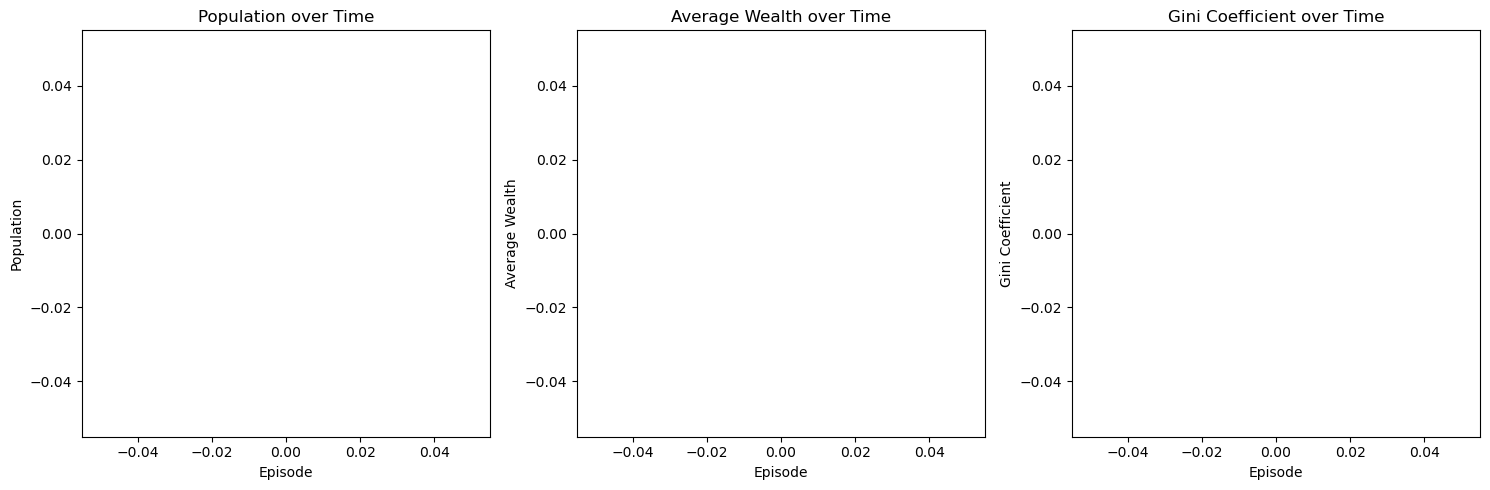

Training complete. Saved final model checkpoint at ./checkpoints\checkpoint_final.pth


In [1]:
# Import necessary libraries
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define the DQN class
class DQN(nn.Module):
    def __init__(self, input_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# Define the SugarscapeEnvironment class with enhanced reward system
class SugarscapeEnvironment:
    def __init__(self, width, height, num_agents, params):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.params = params

        # Initialize environment components
        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.max_sugar_landscape = self.sugar.copy()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        self.timestep = 0

        # Initialize DQN components
        self.observation_space_size = (self.params['vision_range'] * 2 + 1) ** 2 + 2  # Observation size
        self.action_space_size = 5  # Up, Down, Left, Right, Stay
        self.policy_net = DQN(self.observation_space_size, self.action_space_size)
        self.target_net = DQN(self.observation_space_size, self.action_space_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.params['learning_rate'])
        self.memory = deque(maxlen=100000)  # Replay buffer
        self.batch_size = self.params['batch_size']
        self.gamma = self.params['gamma']
        self.epsilon = self.params['epsilon_start']

        # Directory where checkpoints are saved
        self.checkpoint_dir = './checkpoints'  # Change this path as needed

        # Create checkpoint directory if it doesn't exist
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Load latest checkpoint if available
        self.start_episode = self.load_latest_checkpoint()

        # Initialize metrics
        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
    
    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': np.random.randint(1, self.params['vision_range'] + 1),
            'broadcast_radius': max(1, int(np.random.normal(self.params['broadcast_radius'], self.params['broadcast_radius'] / 3))),
            'messages': deque(maxlen=100),
            'destination': None,
            'done': False
        }

    def get_agent_observation(self, agent):
        x, y = agent['x'], agent['y']
        obs_range = self.params['vision_range']
        # Get local sugar levels
        sugar_obs = self.sugar[max(0, y - obs_range):min(self.height, y + obs_range + 1),
                               max(0, x - obs_range):min(self.width, x + obs_range + 1)]
        # Pad the observation if at the edges
        pad_width_x = (max(0, obs_range - x), max(0, x + obs_range + 1 - self.width))
        pad_width_y = (max(0, obs_range - y), max(0, y + obs_range + 1 - self.height))
        sugar_obs = np.pad(sugar_obs, (pad_width_y, pad_width_x), mode='constant', constant_values=0)
        sugar_obs = sugar_obs.flatten()
        # Include agent's own sugar level and metabolism
        agent_features = np.array([agent['sugar'], agent['metabolism']])
        observation = np.concatenate((sugar_obs, agent_features))
        return observation

    def calculate_reward(self, collected_sugar, survived):
        """
        Calculate the reward for an agent based on sugar collected and survival.

        Args:
            collected_sugar (int): Amount of sugar collected in the current step.
            survived (bool): Whether the agent survived the current step.

        Returns:
            float: Calculated reward.
        """
        reward = 0.0
        reward += collected_sugar * self.params['sugar_reward_weight']  # Positive reward for sugar
        if survived:
            reward += self.params['survival_reward']  # Positive reward for survival
        else:
            reward -= self.params['death_penalty']  # Negative reward for death

        # Penalize for not collecting sugar when available
        if collected_sugar == 0:
            reward -= self.params['inaction_penalty']  # Negative reward for inaction

        return reward

    def select_action(self, observation):
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            action = random.randint(0, self.action_space_size - 1)
        else:
            with torch.no_grad():
                observation = torch.tensor(observation, dtype=torch.float32)
                q_values = self.policy_net(observation)
                action = torch.argmax(q_values).item()
        return action

    def move_agent(self, agent, action):
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, max(0, y - 1)),        # Up
            1: (x, min(self.height - 1, y + 1)),  # Down
            2: (max(0, x - 1), y),        # Left
            3: (min(self.width - 1, x + 1), y),   # Right
            4: (x, y)                     # Stay
        }
        new_x, new_y = possible_moves[action]
        if (new_x, new_y) not in self.agent_positions:
            self.agent_positions.remove((agent['x'], agent['y']))
            agent['x'], agent['y'] = new_x, new_y
            self.agent_positions.add((new_x, new_y))
        # else: If the space is occupied, the agent stays in place

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # For each agent, perform action and collect experience
        for agent in self.agents:
            observation = self.get_agent_observation(agent)
            action = self.select_action(observation)
            self.move_agent(agent, action)
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0

            survived = True
            agent['sugar'] -= agent['metabolism']
            done = agent['sugar'] <= 0
            if done:
                survived = False

            # Calculate reward with penalties
            reward = self.calculate_reward(collected_sugar, survived)

            next_observation = self.get_agent_observation(agent)

            # Store experience with reward
            self.memory.append((observation, action, reward, next_observation, done))

            agent['done'] = done

        # Update agent list
        alive_agents = []
        for agent in self.agents:
            if agent['done']:
                agent['death_time'] = self.timestep
                self.dead_agents.append(agent)
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Collect data for metrics
        self.collect_data()
        self.timestep += 1

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return  # Not enough samples to learn

        batch = random.sample(self.memory, self.batch_size)
        observations, actions, rewards, next_observations, dones = zip(*batch)

        # Convert observations to torch tensors efficiently
        observations = torch.tensor(np.array(observations), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_observations = torch.tensor(np.array(next_observations), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        q_values = self.policy_net(observations).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_net(next_observations).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train_model(self, num_episodes, max_timesteps):
        for episode in range(self.start_episode, num_episodes):
            # Reset environment
            self.reset_environment()
            for timestep in range(max_timesteps):
                self.step()
                if not self.agents:
                    break  # All agents have died

            # Calculate total surviving agents
            total_surviving_agents = len(self.agents)
            episode_reward = total_surviving_agents
            print(f"Episode {episode+1}/{num_episodes}, Surviving Agents: {total_surviving_agents}, Epsilon: {self.epsilon:.4f}")

            # Perform learning steps
            for _ in range(self.params.get('learning_steps_per_episode', 1)):
                self.learn()

            # Decay epsilon
            if self.epsilon > self.params['epsilon_min']:
                self.epsilon *= self.params['epsilon_decay']
                self.epsilon = max(self.epsilon, self.params['epsilon_min'])

            # Save checkpoint periodically
            if (episode + 1) % self.params['save_interval'] == 0:
                self.save_checkpoint(episode + 1)
                print(f"Saved checkpoint at episode {episode+1}")

            # Update target network periodically
            if (episode + 1) % self.params['target_update'] == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                print(f"Updated target network at episode {episode+1}")

        # After training, plot metrics
        self.plot_metrics()

    def save_checkpoint(self, episode):
        checkpoint = {
            'episode': episode,
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
        }
        checkpoint_path = os.path.join(self.checkpoint_dir, f"checkpoint_episode_{episode}.pth")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    def load_latest_checkpoint(self):
        # Get list of all checkpoint files
        checkpoint_files = glob.glob(os.path.join(self.checkpoint_dir, 'checkpoint_episode_*.pth'))
        if not checkpoint_files:
            print("No checkpoint found. Starting training from scratch.")
            return 0  # No checkpoint found, start from episode 0

        # Extract episode numbers from filenames
        try:
            episode_numbers = [int(os.path.basename(f).split('_')[-1].split('.')[0]) for f in checkpoint_files]
        except ValueError:
            print("No valid checkpoint files found. Starting training from scratch.")
            return 0

        max_episode = max(episode_numbers)
        latest_checkpoint = os.path.join(self.checkpoint_dir, f'checkpoint_episode_{max_episode}.pth')

        # Load the checkpoint
        try:
            checkpoint = torch.load(latest_checkpoint, map_location=torch.device('cpu'))
            self.policy_net.load_state_dict(checkpoint['model_state_dict'])
            self.target_net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.epsilon = checkpoint['epsilon']
            print(f"Loaded checkpoint from episode {checkpoint['episode']} at {latest_checkpoint}")
            return checkpoint['episode']
        except Exception as e:
            print(f"Failed to load checkpoint from {latest_checkpoint}: {e}")
            print("Starting training from scratch.")
            return 0

    def reset_environment(self):
        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []
        self.timestep = 0

    def plot_metrics(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time')
        plt.xlabel('Episode')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time')
        plt.xlabel('Episode')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time')
        plt.xlabel('Episode')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

# Training Parameters with Enhanced Reward Structure
params = {
    'max_sugar': 5,
    'growth_rate': 1,
    'sugar_peak_frequency': 0.04,
    'sugar_peak_spread': 6,
    'job_center_duration': (40, 100),
    'vision_range': 1,
    'message_expiry': 15,
    'max_relay_messages': 10,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_min': 0.1,
    'epsilon_decay': 0.99,  # Faster decay
    'learning_rate': 5e-5,  # Reduced learning rate
    'batch_size': 128,      # Increased batch size
    'target_update': 5,     # Update target network every 5 episodes
    'broadcast_radius': 15,
    'save_interval': 10,    # Save model every 10 episodes
    'learning_steps_per_episode': 10,  # Number of learning steps per episode
    # New parameters for rewards and penalties
    'sugar_reward_weight': 1.0,    # Reward per unit sugar collected
    'survival_reward': 0.1,        # Reward for surviving each timestep
    'death_penalty': 1.0,          # Penalty for dying
    'inaction_penalty': 0.05       # Penalty for not collecting sugar
}

# Create environment and train
env = SugarscapeEnvironment(width=50, height=50, num_agents=1000, params=params)
num_episodes = 200  # Adjust as needed
max_timesteps = 1000

env.train_model(num_episodes, max_timesteps)

# Save the final model checkpoint
final_checkpoint = {
    'episode': num_episodes,
    'model_state_dict': env.policy_net.state_dict(),
    'optimizer_state_dict': env.optimizer.state_dict(),
    'epsilon': env.epsilon,
}
final_checkpoint_path = os.path.join(env.checkpoint_dir, "checkpoint_final.pth")
torch.save(final_checkpoint, final_checkpoint_path)
print(f"Training complete. Saved final model checkpoint at {final_checkpoint_path}")


In [ ]:
# Import necessary libraries
import random
import numpy as np
import pygame
import torch
import torch.nn as nn
from collections import deque
import matplotlib.pyplot as plt

# Define a global action mapping for consistency
ACTIONS = {
    0: "Up",
    1: "Down",
    2: "Left",
    3: "Right",
    4: "Stay"
}

# Define the DQN class (must match the one used during training)
class DQN(nn.Module):
    def __init__(self, input_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# Define the SugarscapeEnvironmentVisual class for simulation
class SugarscapeEnvironmentVisual:
    def __init__(self, width, height, num_agents, params, checkpoint_path):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.params = params

        # Initialize environment components
        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.max_sugar_landscape = self.sugar.copy()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        # Initialize PyGame
        pygame.init()
        self.cell_size = 8  # Adjusted for better visibility
        self.screen = pygame.display.set_mode((width * self.cell_size, height * self.cell_size))
        pygame.display.set_caption("Sugarscape Simulation - Execution")
        self.clock = pygame.time.Clock()

        self.font = pygame.font.Font(None, 10)

        # Initialize metrics
        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

        # Load trained model
        self.observation_space_size = (self.params['vision_range'] * 2 + 1) ** 2 + 2  # Observation size
        self.action_space_size = 5  # Up, Down, Left, Right, Stay
        self.policy_net = DQN(self.observation_space_size, self.action_space_size)
        
        # Load the checkpoint and extract model_state_dict
        try:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            if 'model_state_dict' in checkpoint:
                self.policy_net.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded model_state_dict from {checkpoint_path}")
            else:
                # If the checkpoint only contains the model's state_dict
                self.policy_net.load_state_dict(checkpoint)
                print(f"Loaded model state_dict directly from {checkpoint_path}")
        except Exception as e:
            print(f"Failed to load checkpoint from {checkpoint_path}: {e}")
            print("Proceeding with randomly initialized model.")
        
        self.policy_net.eval()

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': np.random.randint(1, self.params['vision_range'] + 1),
            'broadcast_radius': max(1, int(np.random.normal(self.params['broadcast_radius'], self.params['broadcast_radius'] / 3))),
            'messages': deque(maxlen=100),
            'destination': None,
            'done': False
        }

    def get_agent_observation(self, agent):
        x, y = agent['x'], agent['y']
        obs_range = self.params['vision_range']
        # Get local sugar levels
        sugar_obs = self.sugar[max(0, y - obs_range):min(self.height, y + obs_range + 1),
                               max(0, x - obs_range):min(self.width, x + obs_range + 1)]
        # Pad the observation if at the edges
        pad_width_x = (max(0, obs_range - x), max(0, x + obs_range + 1 - self.width))
        pad_width_y = (max(0, obs_range - y), max(0, y + obs_range + 1 - self.height))
        sugar_obs = np.pad(sugar_obs, (pad_width_y, pad_width_x), mode='constant', constant_values=0)
        sugar_obs = sugar_obs.flatten()
        # Include agent's own sugar level and metabolism
        agent_features = np.array([agent['sugar'], agent['metabolism']])
        observation = np.concatenate((sugar_obs, agent_features))
        return observation

    def select_action(self, observation):
        with torch.no_grad():
            observation = torch.tensor(observation, dtype=torch.float32)
            q_values = self.policy_net(observation)
            action = torch.argmax(q_values).item()
            # Debug: Print Q-values and selected action
            print(f"Q-Values: {q_values.numpy()}, Selected Action: {ACTIONS[action]}")
        return action

    def move_agent(self, agent, action):
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, max(0, y - 1)),        # Up
            1: (x, min(self.height - 1, y + 1)),  # Down
            2: (max(0, x - 1), y),        # Left
            3: (min(self.width - 1, x + 1), y),   # Right
            4: (x, y)                     # Stay
        }
        new_x, new_y = possible_moves[action]
        if (new_x, new_y) not in self.agent_positions:
            self.agent_positions.remove((agent['x'], agent['y']))
            agent['x'], agent['y'] = new_x, new_y
            self.agent_positions.add((new_x, new_y))
        # else: If the space is occupied, the agent stays in place

    def run_simulation_step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # For each agent, perform action
        for agent in self.agents:
            observation = self.get_agent_observation(agent)
            action = self.select_action(observation)
            self.move_agent(agent, action)
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0

            survived = True
            agent['sugar'] -= agent['metabolism']
            done = agent['sugar'] <= 0
            if done:
                survived = False

            # Calculate reward with penalties (Not used in simulation, but can be logged if needed)
            reward = self.calculate_reward(collected_sugar, survived)

        # Update agent list
        alive_agents = []
        for agent in self.agents:
            if agent['done']:
                agent['death_time'] = self.timestep
                self.dead_agents.append(agent)
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Remove dead agents older than 5 timesteps for visualization clarity
        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        # Collect data for metrics
        self.collect_data()
        self.timestep += 1

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.run_simulation_step()
            self.render()
            self.clock.tick(60)  # Adjust FPS as needed

        self.plot_metrics()
        pygame.quit()

    def render(self):
        self.screen.fill((255, 255, 255)) 

        # Render sugar landscape
        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

        # Render dead agents
        for dead_agent in self.dead_agents:
            pygame.draw.circle(self.screen, (128, 128, 128),
                               (int(dead_agent['x'] * self.cell_size + self.cell_size / 2),
                                int(dead_agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        # Render alive agents
        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)  # White for no sugar
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))  # Gradient from white to yellow

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def plot_metrics(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

# Define a function to load a checkpoint and run the simulation
def run_trained_simulation(checkpoint_episode=None, num_episodes=1, max_timesteps=1000, visualize=True):
    """
    Initialize the Sugarscape environment, load the trained model, and run the simulation.

    Args:
        checkpoint_episode (int): Episode number of the checkpoint to load. If None, load the latest checkpoint.
        num_episodes (int): Number of simulation episodes to run.
        max_timesteps (int): Maximum number of timesteps per episode.
        visualize (bool): If True, visualize the simulation using pygame.
    """
    # Define the same parameters used during training
    params = {
        'max_sugar': 5,
        'growth_rate': 1,
        'sugar_peak_frequency': 0.04,
        'sugar_peak_spread': 6,
        'job_center_duration': (40, 100),
        'vision_range': 1,
        'message_expiry': 15,
        'max_relay_messages': 10,
        'gamma': 0.99,
        'epsilon_start': 1.0,
        'epsilon_min': 0.1,
        'epsilon_decay': 0.99,
        'learning_rate': 5e-5,
        'batch_size': 128,
        'target_update': 5,
        'broadcast_radius': 15,
        'save_interval': 10,
        'learning_steps_per_episode': 10,
        # Reward parameters
        'sugar_reward_weight': 1.0,
        'survival_reward': 0.1,
        'death_penalty': 1.0,
        'inaction_penalty': 0.05
    }

    # Initialize the simulation environment
    env_visual = SugarscapeEnvironmentVisual(
        width=50,
        height=50,
        num_agents=1000,
        params=params,
        checkpoint_path=None  # To be set below
    )

    # Determine the checkpoint file to load
    if checkpoint_episode is not None:
        checkpoint_path = os.path.join(env_visual.checkpoint_dir, f"checkpoint_episode_{checkpoint_episode}.pth")
        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint file {checkpoint_path} does not exist. Cannot run simulation.")
            return
    else:
        # Load the latest checkpoint
        checkpoint_files = glob.glob(os.path.join(env_visual.checkpoint_dir, 'checkpoint_episode_*.pth'))
        if checkpoint_files:
            try:
                episode_numbers = [int(os.path.basename(f).split('_')[-1].split('.')[0]) for f in checkpoint_files]
                max_episode = max(episode_numbers)
                checkpoint_path = os.path.join(env_visual.checkpoint_dir, f'checkpoint_episode_{max_episode}.pth')
            except ValueError:
                print("No valid checkpoint files found. Cannot run simulation.")
                return
        else:
            print("No checkpoint found. Cannot run simulation.")
            return

    # Update the checkpoint path in the environment
    env_visual.policy_net = DQN(env_visual.observation_space_size, env_visual.action_space_size)
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        if 'model_state_dict' in checkpoint:
            env_visual.policy_net.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded model_state_dict from {checkpoint_path}")
        else:
            # If the checkpoint only contains the model's state_dict
            env_visual.policy_net.load_state_dict(checkpoint)
            print(f"Loaded model state_dict directly from {checkpoint_path}")
    except Exception as e:
        print(f"Failed to load checkpoint from {checkpoint_path}: {e}")
        print("Proceeding with randomly initialized model.")

    env_visual.policy_net.eval()

    # Run the simulation
    for episode in range(num_episodes):
        print(f"Starting Simulation Episode {episode + 1}/{num_episodes}")
        env_visual.reset_environment()
        env_visual.run_simulation(max_timesteps=max_timesteps)
        print(f"Completed Simulation Episode {episode + 1}/{num_episodes}")

# Example usage:
# To run a single simulation episode with visualization:
# run_trained_simulation(num_episodes=1, visualize=True)

# To run multiple simulation episodes without visualization:
# run_trained_simulation(num_episodes=5, visualize=False)
